- Análisis de densidad
- Análisis de velocidad del agua
- Análsis de velocidad del viento 
- Comparación entre las 3 anteriores y obtención de la densidad espectral

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib as mpl

from sklearn.linear_model import LinearRegression

# Importar y arreglar datos

In [3]:
feb16 = xr.open_dataset("data/adcp2012feb.nc")
newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))

UV_burst = xr.open_dataset("data/UV_burst.nc") #max var viento
EN_burst = xr.open_dataset("data/EastNorth_burst.nc") 

In [4]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [5]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [6]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

In [7]:
NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

In [8]:
ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

In [9]:
PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [10]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [18]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 1.13493621)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index
dfw.head()

,u,v
TIMESTAMP,,
2011-10-27 15:42:00,-1.205631,-0.387069
2011-10-27 15:48:00,-2.399888,-0.653582
2011-10-27 15:54:00,-2.582782,-0.729539
2011-10-27 16:00:00,-2.865752,-0.723986
2011-10-27 16:06:00,-2.394419,-0.427632


In [19]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)
Q.tail()

,fecha,caudal
4215,2012-03-15 22:45:00,227.0
4216,2012-03-15 23:00:00,226.0
4217,2012-03-15 23:15:00,226.0
4218,2012-03-15 23:30:00,226.0
4219,2012-03-15 23:45:00,222.0


In [20]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)
Q.head()

,10s
index,
2011-07-07 00:00:00,8.77
2011-07-07 00:15:00,8.77
2011-07-07 00:30:00,8.77
2011-07-07 00:45:00,8.39
2011-07-07 01:00:00,8.77


In [21]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

## Densidad

In [22]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [23]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [24]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [25]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [26]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

# Todos los datos

In [40]:
DC_1["Temperature"].min()

7.255386463071261

In [28]:
wdf = dfw.loc[datetime.date(2012,1,16):datetime.date(2012,3,30)]
Qdf = Q.loc[datetime.date(2012,1,16):datetime.date(2012,3,30)]

dc1 = DC_1.loc[datetime.date(2012,1,18):datetime.date(2012,3,21)]
dc2 = DC_2.loc[datetime.date(2012,1,18):datetime.date(2012,3,21)]
dc3 = DC_3.loc[datetime.date(2012,1,18):datetime.date(2012,3,21)]
dc4 = DC_4.loc[datetime.date(2012,1,18):datetime.date(2012,3,21)]

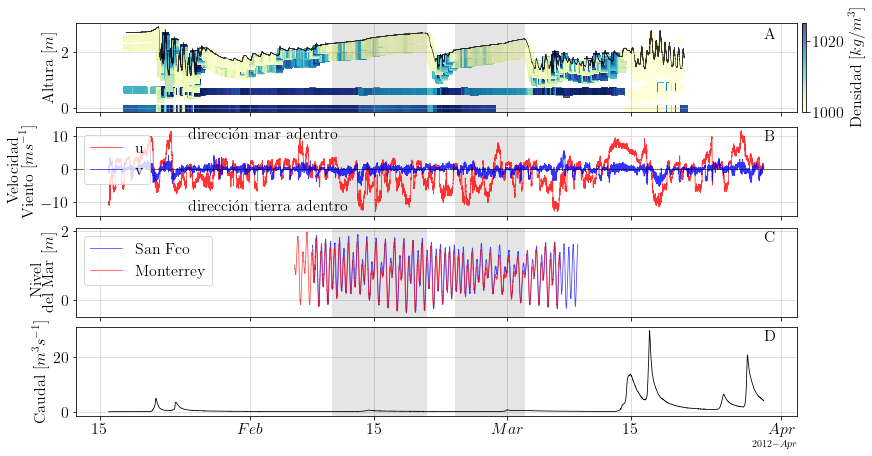

In [31]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax1, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)
ax1.text(pd.to_datetime('2012-3-30 00:00:00'), 2.5, 'A',
          fontsize=16)

ax2.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax2.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax2.plot(snfco.index, snfco.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mnty.index, mnty.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.text(pd.to_datetime('2012-3-30 00:00:00'), 1.7, 'C',
          fontsize=16)

ax3.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax3.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax3.set_ylabel(r"Velocidad\\Viento "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf['u'].values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.plot(wdf.index, wdf['v'].values, color='b', alpha=0.8, linewidth=0.8, label='v')
ax3.legend(loc='upper left',
          fontsize=16);
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
ax3.text(pd.to_datetime('2012-3-30 00:00:00'), 8.7, 'B',
          fontsize=16)
ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
          fontsize=16)
ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
          fontsize=16)

ax4.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax4.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax4.plot(Qdf.index, Qdf['10s'].values/35.315 , c='k', linewidth=0.8);
ax4.set_ylabel(r"Caudal $[m^3s^{-1}]$",
          fontsize=16)
# ax4.set_xlabel(r"GMT",
#           fontsize=16)
# ax4.set_title(r"Discharge every 15 minutes",
#           fontsize=16)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.text(pd.to_datetime('2012-3-30 00:00:00'), 26, 'D',
          fontsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

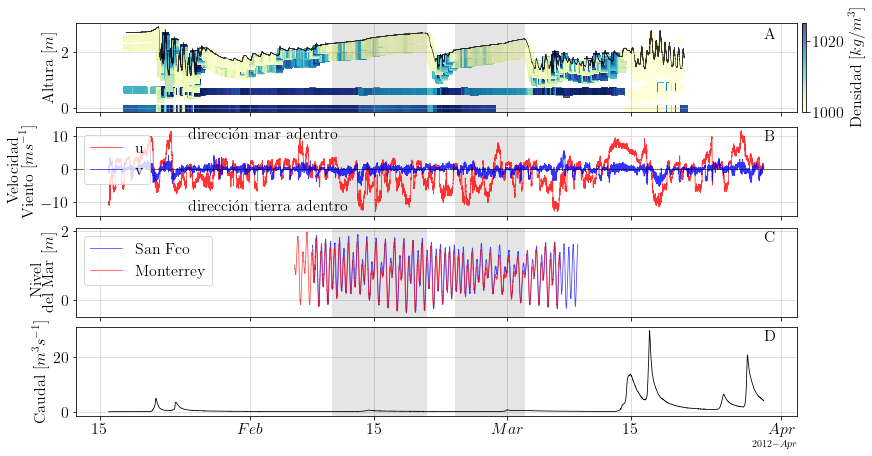

In [31]:
fig, (ax1, ax3, ax2, ax4) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax1, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)
ax1.text(pd.to_datetime('2012-3-30 00:00:00'), 2.5, 'A',
          fontsize=16)

ax2.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax2.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax2.plot(snfco.index, snfco.values, alpha=0.7, linewidth=0.8, c="b", label='San Fco');
ax2.plot(mnty.index, mnty.values, alpha=0.7, linewidth=0.8, c="r", label='Monterrey');
ax2.legend(loc='upper left',
          fontsize=16);
ax2.set_ylabel(r'Nivel\\del Mar [$m$]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.text(pd.to_datetime('2012-3-30 00:00:00'), 1.7, 'C',
          fontsize=16)

ax3.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax3.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax3.set_ylabel(r"Velocidad\\Viento "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf['u'].values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.plot(wdf.index, wdf['v'].values, color='b', alpha=0.8, linewidth=0.8, label='v')
ax3.legend(loc='upper left',
          fontsize=16);
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
ax3.text(pd.to_datetime('2012-3-30 00:00:00'), 8.7, 'B',
          fontsize=16)
ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
          fontsize=16)
ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
          fontsize=16)

ax4.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax4.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax4.plot(Qdf.index, Qdf['10s'].values/35.315 , c='k', linewidth=0.8);
ax4.set_ylabel(r"Caudal $[m^3s^{-1}]$",
          fontsize=16)
# ax4.set_xlabel(r"GMT",
#           fontsize=16)
# ax4.set_title(r"Discharge every 15 minutes",
#           fontsize=16)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.text(pd.to_datetime('2012-3-30 00:00:00'), 26, 'D',
          fontsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

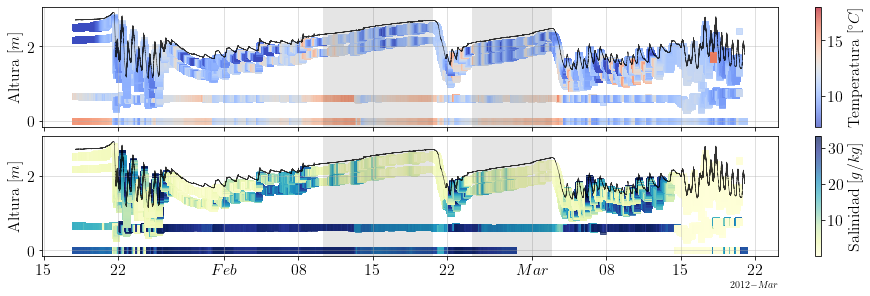

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 4), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
# ax1.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax1.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=110, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=80, alpha=0.1)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax1.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['Temperature'], marker='s', alpha=0.7, cmap=cm.coolwarm, vmin=7.25, vmax=18)
ax1.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['Temperature'], marker='s', alpha=0.7, cmap=cm.coolwarm, vmin=7.25, vmax=18)
ax1.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['Temperature'], marker='s', alpha=0.7, cmap=cm.coolwarm, vmin=7.25, vmax=18)
ax1.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['Temperature'], marker='s', alpha=0.7, cmap=cm.coolwarm, vmin=7.25, vmax=18)
cbar2 = fig.colorbar(scat, ax=ax1)
cbar2.set_label("Temperatura [$^{\circ}C$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


ax2.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax2.axvline(x=datetime.datetime(2012,2,15,12,30,0), color='k', linewidth=110, alpha=0.1)
ax2.axvline(x=datetime.datetime(2012,2,28,2,30,0), color='k', linewidth=80, alpha=0.1)
ax2.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
scat = ax2.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['Salinity'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=0.1, vmax=33.24)
ax2.scatter(dc2.index, dc1.loc[dc2.index]['Depth'].values-dc2['Depth'].values, c=dc2['Salinity'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=0.1, vmax=33.24)
ax2.scatter(dc3.index, dc1.loc[dc3.index]['Depth'].values-dc3['Depth'].values, c=dc3['Salinity'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=0.1, vmax=33.24)
ax2.scatter(dc4.index, dc1.loc[dc4.index]['Depth'].values-dc4['Depth'].values, c=dc4['Salinity'], marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=0.1, vmax=33.24)
cbar3 = fig.colorbar(scat, ax=ax2)
cbar3.set_label("Salinidad [$g/kg$]", loc='center',
          fontsize=16)
cbar3.ax.tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

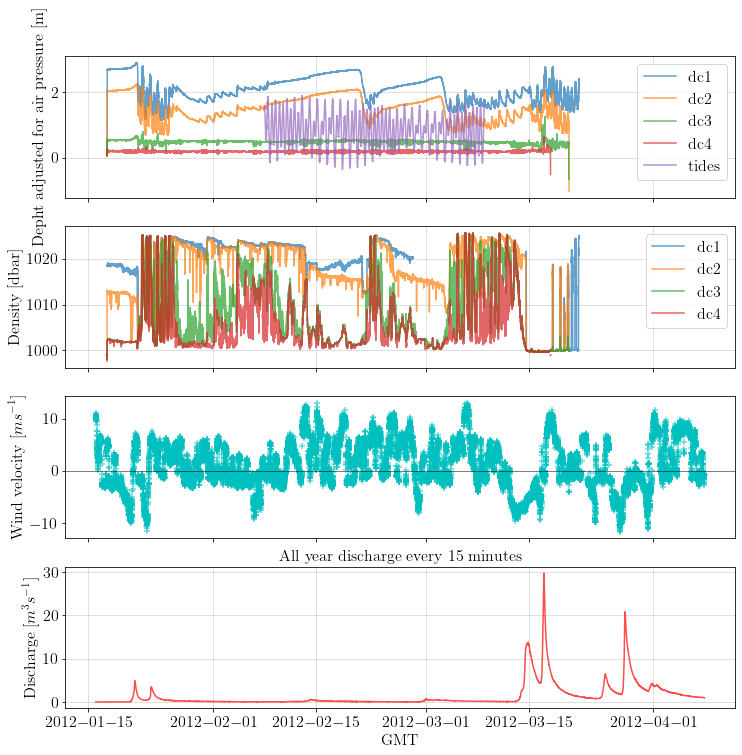

In [77]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 12), sharex=True)

ax1.plot(DC_1.index, DC_1['Depth'], alpha=0.7);
ax1.plot(DC_2.index, DC_2['Depth'], alpha=0.7);
ax1.plot(DC_3.index, DC_3['Depth'], alpha=0.7);
ax1.plot(DC_4.index, DC_4['Depth'], alpha=0.7);
ax1.plot(snfco.index, snfco.values, alpha=0.7);
ax1.legend(["dc1","dc2", "dc3", "dc4", "tides"], loc='upper right',
          fontsize=16);
ax1.set_ylabel('Depht adjusted for air pressure [m]',
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2.plot(DC_1.index, DC_1['densidad'], alpha=0.7);
ax2.plot(DC_2.index, DC_2['densidad'], alpha=0.7);
ax2.plot(DC_3.index, DC_3['densidad'], alpha=0.7);
ax2.plot(DC_4.index, DC_4['densidad'], alpha=0.7);
ax2.legend(["dc1","dc2", "dc3", "dc4"], loc='upper right',
          fontsize=16);
ax2.set_ylabel('Density [dbar]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf['u'].values, color='c', marker = '+', alpha=0.6)
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

ax4.plot(Qdf.index, Qdf['10s'].values/35.315 , c='r', alpha=0.7);
ax4.set_ylabel(r"Discharge $[m^3s^{-1}]$",
          fontsize=16)
ax4.set_xlabel(r"GMT",
          fontsize=16)
ax4.set_title(r"Discharge every 15 minutes",
          fontsize=16)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)

# Tiempo estudiado

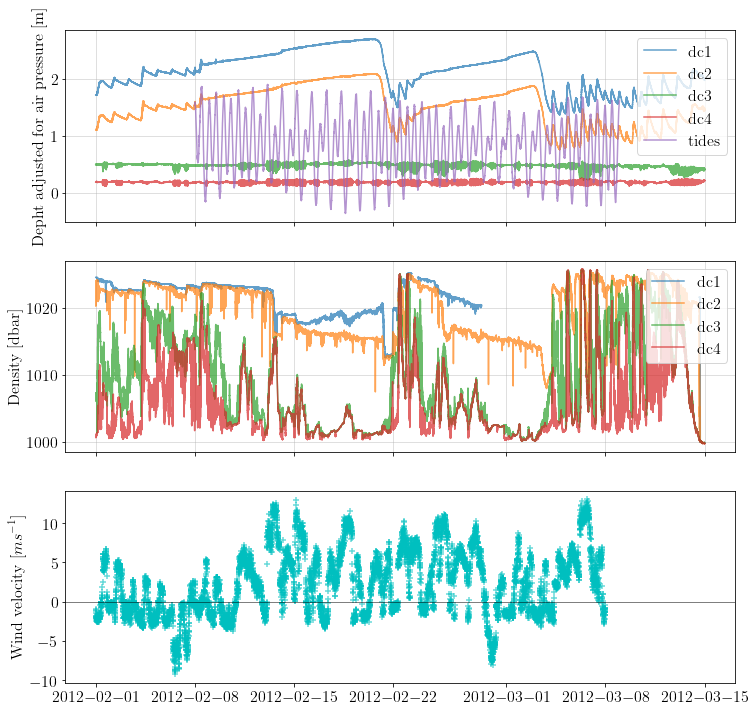

In [52]:
x_dc1 = DC_1.index
y_dc1 = DC_1['Depth'].values
x_dc2 = DC_2.index
y_dc2 = DC_2['Depth'].values
x_dc3 = DC_3.index
y_dc3 = DC_3['Depth'].values
x_dc4 = DC_4.index
y_dc4 = DC_4['Depth'].values

wdf = dfw['u'].loc[datetime.date(2012,2,1):datetime.date(2012,3,8)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax1.plot(x_dc1,y_dc1, alpha=0.7);
ax1.plot(x_dc2,y_dc2, alpha=0.7);
ax1.plot(x_dc3,y_dc3, alpha=0.7);
ax1.plot(x_dc4,y_dc4, alpha=0.7);
ax1.plot(snfco.index,snfco.values, alpha=0.7);
ax1.legend(["dc1","dc2", "dc3", "dc4", "tides"], loc='upper right',
          fontsize=16);
ax1.set_ylabel('Depht adjusted for air pressure [m]',
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2.plot(x_dc1,rho_dc1, alpha=0.7);
ax2.plot(x_dc2,rho_dc2, alpha=0.7);
ax2.plot(x_dc3,rho_dc3, alpha=0.7);
ax2.plot(x_dc4,rho_dc4, alpha=0.7);
ax2.legend(["dc1","dc2", "dc3", "dc4"], loc='upper right',
          fontsize=16);
ax2.set_ylabel('Density [dbar]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c', marker = '+', alpha=0.6)
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

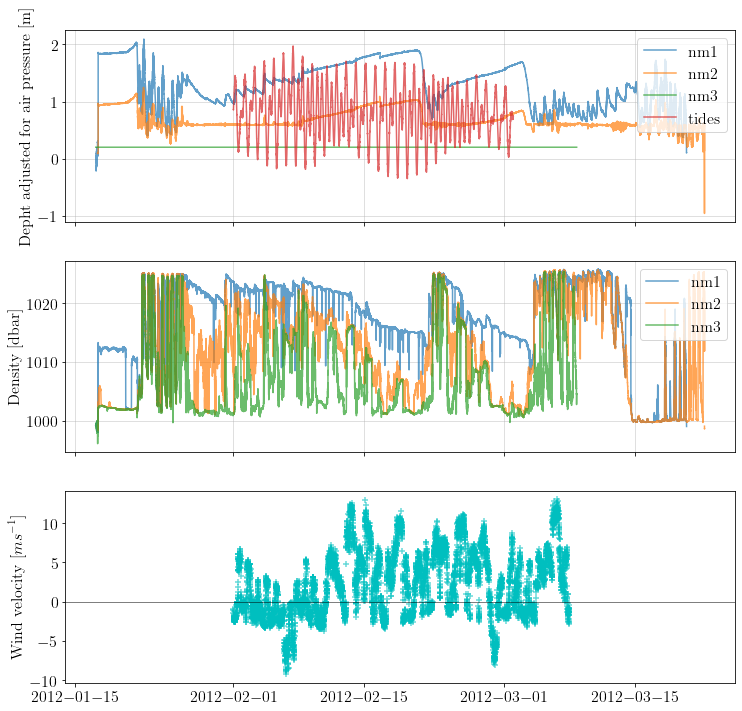

In [109]:
x_nm1 = NM_1.index
y_nm1 = NM_1['Depth'].values
x_nm2 = NM_2.index
y_nm2 = NM_2['Depth'].values
x_nm3 = NM_3.index
y_nm3 = NM_3['Depth'].values

wdf = dfw['u'].loc[datetime.date(2012,2,1):datetime.date(2012,3,8)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax1.plot(x_nm1,y_nm1, alpha=0.7);
ax1.plot(x_nm2,y_nm2, alpha=0.7);
ax1.plot(x_nm3,y_nm3, alpha=0.7);
ax1.plot(snfco.index, snfco.values, alpha=0.7);
ax1.legend(["nm1","nm2", "nm3", "tides"], loc='upper right',
          fontsize=16);
ax1.set_ylabel('Depht adjusted for air pressure [m]',
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2.plot(x_nm1,rho_nm1, alpha=0.7);
ax2.plot(x_nm2,rho_nm2, alpha=0.7);
ax2.plot(x_nm3,rho_nm3, alpha=0.7);
ax2.legend(["nm1","nm2", "nm3"], loc='upper right',
          fontsize=16);
ax2.set_ylabel('Density [dbar]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c', marker = '+', alpha=0.6)
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

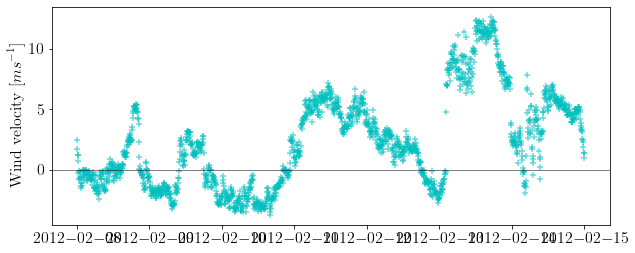

In [110]:
wdf = dfw.loc[datetime.date(2012,2,8):datetime.date(2012,2,15)]

fig, (ax3) = plt.subplots(nrows=1, figsize=(10, 4))

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf['u'].values,color='c', marker = '+', alpha=0.6)
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

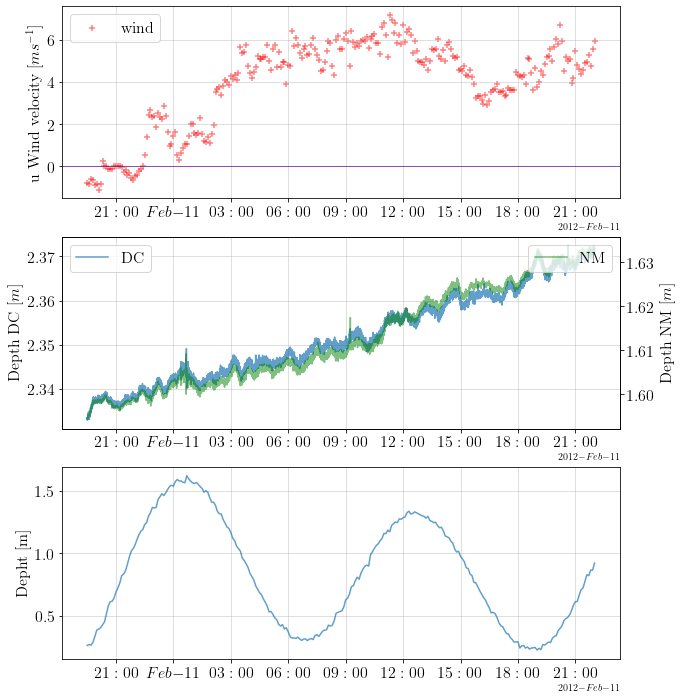

In [139]:
fig, (ax1, ax2, ax4) = plt.subplots(nrows=3, figsize=(10, 12))

locator1 = mdates.AutoDateLocator()
formatter1 = mdates.ConciseDateFormatter(locator1)
locator2 = mdates.AutoDateLocator()
formatter2 = mdates.ConciseDateFormatter(locator2)

datw1 = dfw.loc[datetime.datetime(2012,2,10,19,30,0):datetime.datetime(2012,2,11,22,0,0)]

prof_DC = DC_1.loc[datetime.datetime(2012,2,10,19,30,0):datetime.datetime(2012,2,11,22,0,0)]
prof_NM = NM_1.loc[datetime.datetime(2012,2,10,19,30,0):datetime.datetime(2012,2,11,22,0,0)]

p_sf = snfco.loc[datetime.datetime(2012,2,10,19,30,0):datetime.datetime(2012,2,11,22,0,0)]

ax1.set_ylabel(r"u Wind velocity $[ms^{-1}]$",
          fontsize=16)
ax1.scatter(datw1.index, -datw1['u'], color='r',alpha=0.5, marker='+')
ax1.legend(["wind"], loc='upper left', fontsize=16);
ax1.axhline(y=0, color='r', linewidth=0.5, alpha=0.8)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='b', linewidth=0.5, alpha=0.8)

ax2.plot(prof_DC.index, prof_DC['Depth'], alpha=0.7);
ax2.set_ylabel('Depth DC $[m]$', fontsize=16)
# ax2.set_ylim(2.68, 2.7)
ax2.grid(alpha=0.5)
ax2.legend(["DC"], loc='upper left',
          fontsize=16);

ax3 = ax2.twinx()
ax3.set_ylabel(r"Depth NM $[m]$",
          fontsize=16)
ax3.plot(prof_NM.index, prof_NM['Depth'], alpha=0.5, c='g');
# ax3.set_ylim(1.8775, 1.8975)
ax3.legend(["NM"], loc='upper right',
          fontsize=16);

ax4.plot(p_sf.index, p_sf.values, alpha=0.7);
ax4.set_ylabel('Depht [m]',
          fontsize=16)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)


ax1.xaxis.set_major_locator(locator1)
ax1.xaxis.set_major_formatter(formatter1)
ax2.xaxis.set_major_locator(locator2)
ax2.xaxis.set_major_formatter(formatter2)
ax3.xaxis.set_major_locator(locator2)
ax3.xaxis.set_major_formatter(formatter2)
ax4.xaxis.set_major_locator(locator2)
ax4.xaxis.set_major_formatter(formatter2)


In [132]:
#2012-02-09 20:06:00 cuando el agua esta quieta

DC_1.loc[datetime.datetime(2012,2,9,20,6,0)] - NM_1.loc[datetime.datetime(2012,2,9,20,6,0)]
# DC_1.loc[datetime.datetime(2012,2,9,20,6,0)] - PC_1.loc[datetime.datetime(2012,2,9,20,6,0)]
# DC_1.loc[datetime.datetime(2012,2,9,20,6,0)] - ML_1.loc[datetime.datetime(2012,2,9,20,6,0)]

Depth          0.742830
Salinity       0.457496
Temperature   -0.949224
densidad       0.551452
Name: 2012-02-09 20:06:00, dtype: float64

# Velocidad

## UV rotada en dir del viento

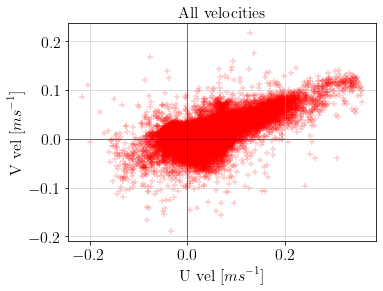

In [39]:
fig, (ax1) = plt.subplots(nrows=1)

ax1.scatter(UV_burst.u.values, UV_burst.v.values, c='r', marker='+', alpha=0.2);
ax1.set_ylabel(r"V vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"U vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"All velocities",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

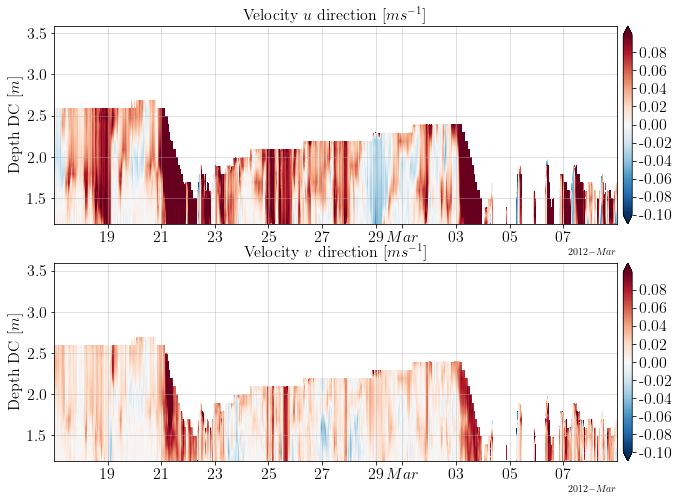

In [32]:
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

ax1.set_title(r"Velocity $u$ direction "
          r"$[ms^{-1}]$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

contourf_ = ax1.contourf(UV_burst.time.values, y_bin,
                         np.transpose(UV_burst.u.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

ax2.set_title(r"Velocity $v$ direction "
          r"$[ms^{-1}]$",
          fontsize=16)
contourf_2 = ax2.contourf(UV_burst.time.values, y_bin,
                         np.transpose(UV_burst.v.values),
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, extend='both')
cbar = fig.colorbar(contourf_2, ax=ax2, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax2.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

plt.show() 

## Rotada en dir de las vel del agua

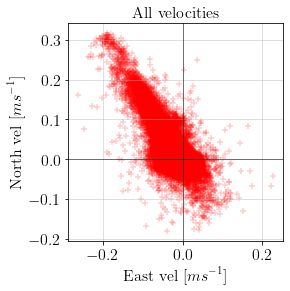

In [30]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(4, 4))

ax1.scatter(EN_burst.east.values, EN_burst.north.values, c='r', marker='+', alpha=0.2);
ax1.set_ylabel(r"North vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"East vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"All velocities",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

In [33]:
eastt = EN_burst.east.values
northtt = EN_burst.north.values

X = eastt[~np.isnan(eastt)].reshape(-1, 1)
y = northtt[~np.isnan(northtt)].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
coef = reg.coef_
print(reg.intercept_)
print(reg.coef_)

[0.00310397]
[[-1.13493621]]


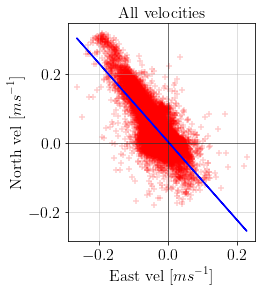

In [31]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(4, 4))

ax1.scatter(EN_burst.east.values, EN_burst.north.values, c='r', marker='+', alpha=0.2);
ax1.plot(X,y_pred, c='b')
ax1.set_ylabel(r"North vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"East vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"All velocities",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

In [34]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

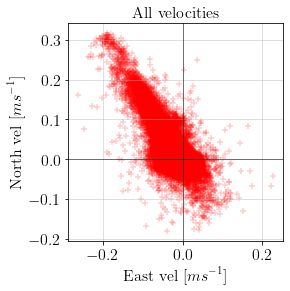

In [40]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(4, 4))

ax1.scatter(df_east.values, df_north.values, c='r', marker='+', alpha=0.2);
ax1.set_ylabel(r"North vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"East vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"All velocities",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

In [35]:
angulo = 180*np.arctan(-coef)/np.pi
print(180*np.arctan(-coef)/np.pi)

[[48.616504]]


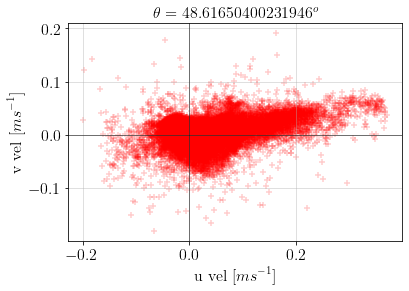

In [46]:
fig, (ax1) = plt.subplots(nrows=1)

ax1.scatter(df_u.values, df_v.values, c='r', marker='+', alpha=0.2);
ax1.set_ylabel(r"v vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"u vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"$\theta = $ " + str(angulo[0,0]) + "$^o$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

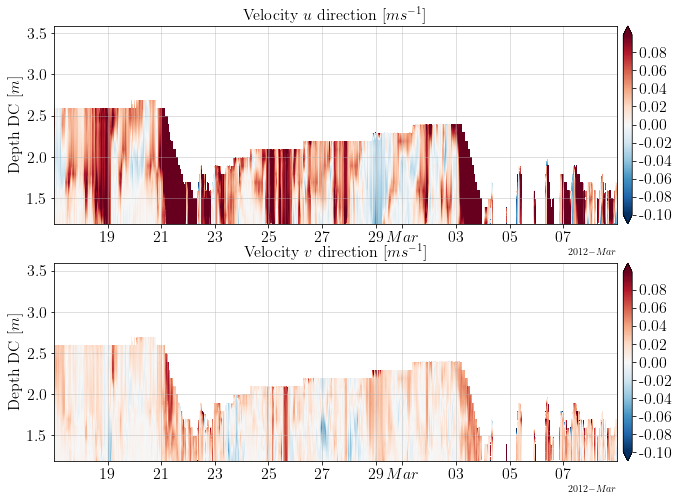

In [47]:
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

ax1.set_title(r"Velocity $u$ direction "
          r"$[ms^{-1}]$",
          fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

contourf_ = ax1.contourf(df_u.index, y_bin,
                         np.transpose(df_u.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

ax2.set_title(r"Velocity $v$ direction "
          r"$[ms^{-1}]$",
          fontsize=16)
contourf_2 = ax2.contourf(df_v.index, y_bin,
                         np.transpose(df_v.values),
                         levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                         vmax=vmax, vmin=vmin, extend='both')
cbar = fig.colorbar(contourf_2, ax=ax2, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax2.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

plt.show() 

# Viento

In [94]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

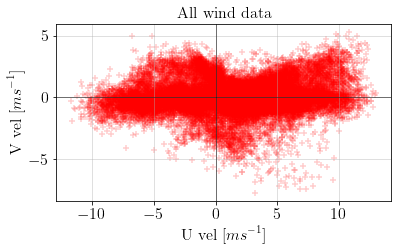

In [95]:
#hacia donde se dirige el viento (positivo offshore)
fig, (ax1) = plt.subplots(nrows=1)

ax1.scatter(-dfw['u'].values, -dfw['v'].values, c='r', marker='+', alpha=0.2);
ax1.set_ylabel(r"V vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_xlabel(r"U vel "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax1.set_title(r"All wind data",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.axvline(x=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_aspect('equal', 'box')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

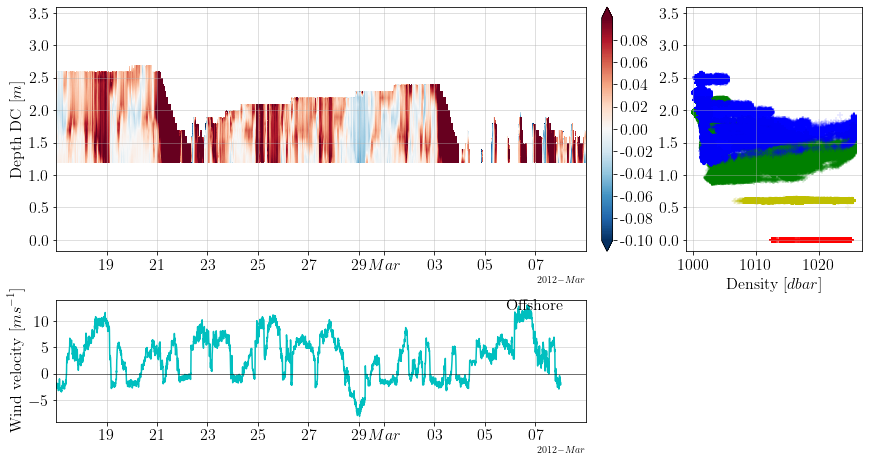

In [70]:
wdf = dfw['u'].loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]
dc1 = DC_1.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc2 = DC_2.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc3 = DC_3.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc4 = DC_4.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
y_bin = np.linspace(1.19, 3.59, 25)

#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(4, 8, figure=fig)

#Grafico de velocidad del agua (color map)
ax1 = fig.add_subplot(gs[:2, :6])
contourf_ = ax1.contourf(UV_burst.time.values, y_bin,
                         np.transpose(UV_burst.u.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#Grafico velocidad viento
ax3 =  fig.add_subplot(gs[2, :6],sharex=ax1)
ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, -wdf.values,color='c')
ax3.axhline(y=0, color='k', linewidth=0.5)
# ax3.text(pd.to_datetime('2012-3-16 16:00:00'),8, 'Offshore')
# ax3.annotate('Offshore', (0.85, 0.05),
#              fontsize=16,
#                xycoords='axes fraction', va='center')
ax3.annotate('Offshore', (0.85, 0.95),
          fontsize=16,
               xycoords='axes fraction', va='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#Grafico densidad
ax2 = fig.add_subplot(gs[:2, 6:], sharey=ax1)
ax2.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r', alpha=0.1)
ax2.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y', alpha=0.1)
ax2.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g', alpha=0.1)
ax2.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b', alpha=0.1)
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax3.grid(alpha=0.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 

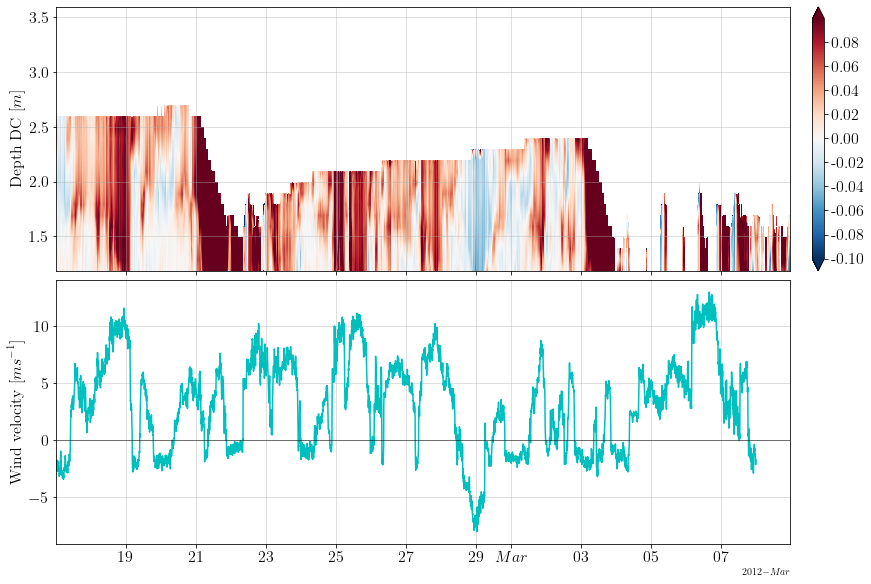

In [28]:
wdf = dfw['u'].loc[datetime.date(2012,2,17):datetime.date(2012,3,8)]
dc1 = DC_1.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc2 = DC_2.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc3 = DC_3.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
dc4 = DC_4.loc[datetime.datetime(2012,2,17,0,2,30):datetime.datetime(2012,3,8,23,47,30)]
y_bin = np.linspace(1.19, 3.59, 25)

#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax3) = plt.subplots(nrows=2, figsize=(12, 8), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
contourf_ = ax1.contourf(UV_burst.time.values, y_bin,
                         np.transpose(UV_burst.u.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, -wdf.values,color='c')
ax3.axhline(y=0, color='k', linewidth=0.5)
# ax3.text(pd.to_datetime('2012-3-16 16:00:00'),8, 'Offshore')
# ax3.annotate('Offshore', (0.85, 0.05),
#              fontsize=16,
#                xycoords='axes fraction', va='center')
# ax3.annotate('Offshore', (0.85, 0.95),
#           fontsize=16,
#                xycoords='axes fraction', va='center')
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax3.grid(alpha=0.5)
plt.show() 

# (1) Estado cerrado de la boca

## First breach

We are going to analyse 4 wind events

In [96]:
bu1 = UV_burst.sel(time=slice("2012-02-17","2012-02-21")).u
w1 = dfw.loc[datetime.date(2012,2,17):datetime.date(2012,2,22)]

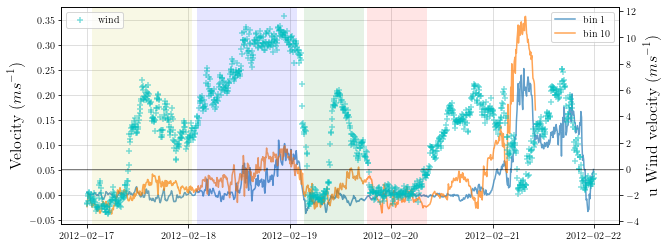

In [88]:


fig, (ax1) = plt.subplots(figsize=(10, 4))

ax1.plot(bu1.time.values, bu1.isel(bin=0).values, alpha=0.7);
ax1.plot(bu1.time.values, bu1.isel(bin=10).values, alpha=0.7);
ax1.legend(["bin 1", "bin 10"], loc='upper right');
ax1.set_ylabel(r"Velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.axvline(x=datetime.datetime(2012,2,20,1,30,0), color='r', linewidth=60, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,19,10,30,0), color='g', linewidth=60, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,18,14,0,0), color='b', linewidth=100, alpha=0.1)
ax1.axvline(x=datetime.datetime(2012,2,17,13,0,0), color='y', linewidth=100, alpha=0.1)
# ax1.text(pd.to_datetime('2012-3-16'),2.95, '(A)')

ax4 = ax1.twinx()
ax4.set_ylabel(r"u Wind velocity "
          r"$\displaystyle(ms^{-1})$",
          fontsize=16)
ax4.scatter(w1.index, -w1['u'], color='c',alpha=0.5, marker='+')
ax4.legend(["wind"], loc='upper left');
ax4.axhline(y=0, color='k', linewidth=0.5)


### Tramo azul

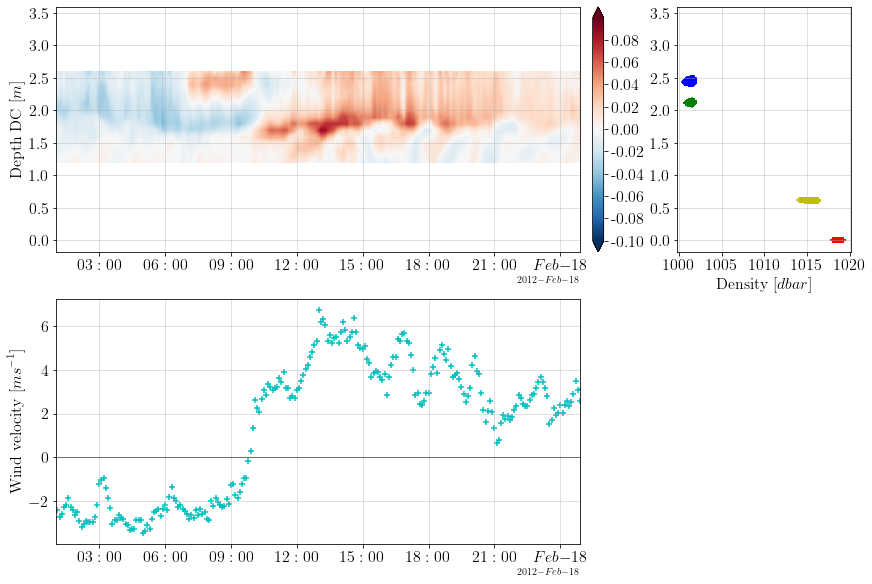

In [102]:
df = bu1.sel(time=slice("2012-02-17 1:00:00","2012-02-18 1:00:00"))
wdf = dfw['u'].loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig)


# ax1.set_title(r"Velocity 1st breach "
#           r"$\displaystyle(ms^{-1})$",
#           fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

ax1 = fig.add_subplot(gs[0, :6])
contourf_ = ax1.contourf(df.time.values, y_bin,
                         np.transpose(df.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax3 =  fig.add_subplot(gs[1, :6],sharex=ax1)
ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c',marker='+')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(gs[0, 6:], sharey=ax1)
ax2.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r')
ax2.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y')
ax2.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g')
ax2.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b')
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.show() 

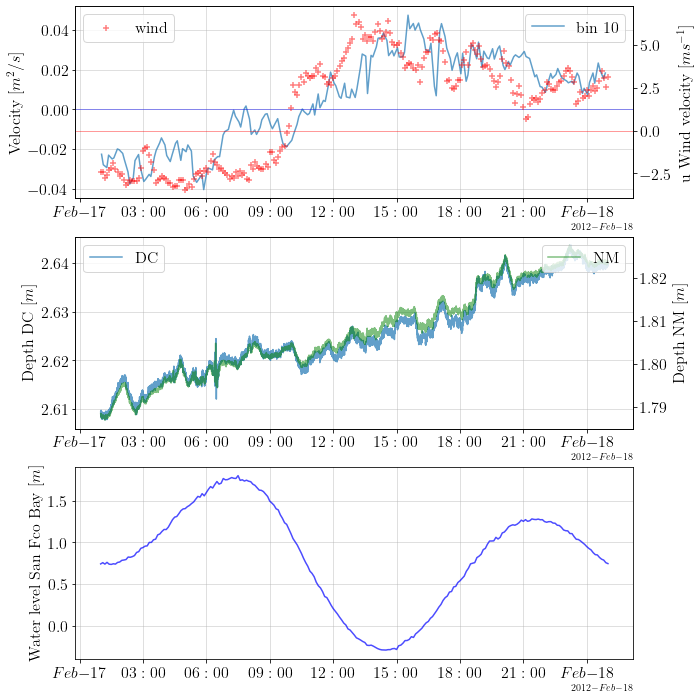

In [103]:
fig, (ax1, ax2, ax5) = plt.subplots(nrows=3, figsize=(10, 12))

locator1 = mdates.AutoDateLocator()
formatter1 = mdates.ConciseDateFormatter(locator1)
locator2 = mdates.AutoDateLocator()
formatter2 = mdates.ConciseDateFormatter(locator2)

dat1 = df
datw1 = dfw.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]

prof_DC = DC_1.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
prof_NM = NM_1.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,17,1,0,0):datetime.datetime(2012,2,18,1,0,0)]

ax1.plot(dat1.time.values, dat1.isel(bin=9), alpha=0.7);
ax1.legend(["bin 10"], loc='upper right', fontsize=16);
ax1.set_ylabel('Velocity $[m^2/s]$', fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='b', linewidth=0.5, alpha=0.8)

ax2.plot(prof_DC.index, prof_DC['Depth'], alpha=0.7);
ax2.set_ylabel('Depth DC $[m]$', fontsize=16)
# ax2.set_ylim(2.68, 2.7)
ax2.grid(alpha=0.5)
ax2.legend(["DC"], loc='upper left',
          fontsize=16);

ax3 = ax2.twinx()
ax3.set_ylabel(r"Depth NM $[m]$",
          fontsize=16)
ax3.plot(prof_NM.index, prof_NM['Depth'], alpha=0.5, c='g');
# ax3.set_ylim(1.8775, 1.8975)
ax3.legend(["NM"], loc='upper right',
          fontsize=16);

ax4 = ax1.twinx()
ax4.set_ylabel(r"u Wind velocity $[ms^{-1}]$",
          fontsize=16)
ax4.scatter(datw1.index, -datw1['u'], color='r',alpha=0.5, marker='+')
ax4.legend(["wind"], loc='upper left', fontsize=16);
ax4.axhline(y=0, color='r', linewidth=0.5, alpha=0.8)

ax5.set_ylabel(r"Water level San Fco Bay $[m]$",
          fontsize=16)
ax5.plot(sf.index, sf.values, color='b',alpha=0.7)
ax5.grid(alpha=0.5)

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)


ax1.xaxis.set_major_locator(locator1)
ax1.xaxis.set_major_formatter(formatter1)
ax2.xaxis.set_major_locator(locator2)
ax2.xaxis.set_major_formatter(formatter2)
ax3.xaxis.set_major_locator(locator2)
ax3.xaxis.set_major_formatter(formatter2)

ax4.xaxis.set_major_locator(locator1)
ax4.xaxis.set_major_formatter(formatter1)
ax5.xaxis.set_major_locator(locator1)
ax5.xaxis.set_major_formatter(formatter1)

In [45]:
sf

,Verified (m)
index,
2012-02-17 01:00:00,0.742
2012-02-17 01:06:00,0.757
2012-02-17 01:12:00,0.740
2012-02-17 01:18:00,0.761
2012-02-17 01:24:00,0.739
...,...
2012-02-18 00:36:00,0.820
2012-02-18 00:42:00,0.799
2012-02-18 00:48:00,0.788


<ipython-input-104-b0ea5d0e3321>:46: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


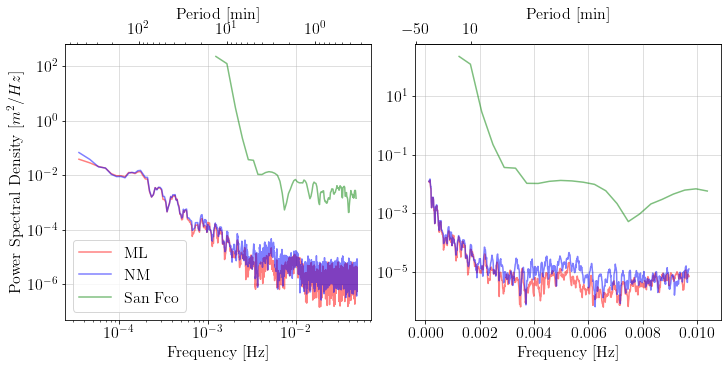

In [104]:
h_dc = prof_DC['Depth'] - prof_DC['Depth'].mean()
h_nm = prof_NM['Depth'] - prof_NM['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=10)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='ML')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='NM')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

### Tramo azul

In [105]:
df = bu1.sel(time=slice("2012-02-18 1:00:00","2012-02-19 1:00:00"))

wdf = dfw['u'].loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

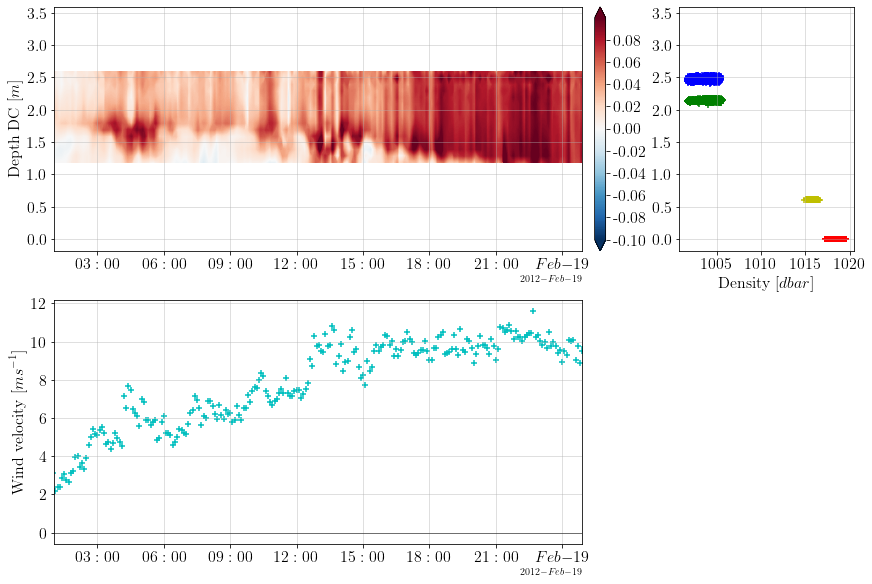

In [106]:


y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig)


# ax1.set_title(r"Velocity 1st breach "
#           r"$\displaystyle(ms^{-1})$",
#           fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

ax1 = fig.add_subplot(gs[0, :6])
contourf_ = ax1.contourf(df.time.values, y_bin,
                         np.transpose(df.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax3 =  fig.add_subplot(gs[1, :6],sharex=ax1)
ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c',marker='+')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(gs[0, 6:], sharey=ax1)
ax2.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r')
ax2.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y')
ax2.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g')
ax2.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b')
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.show() 

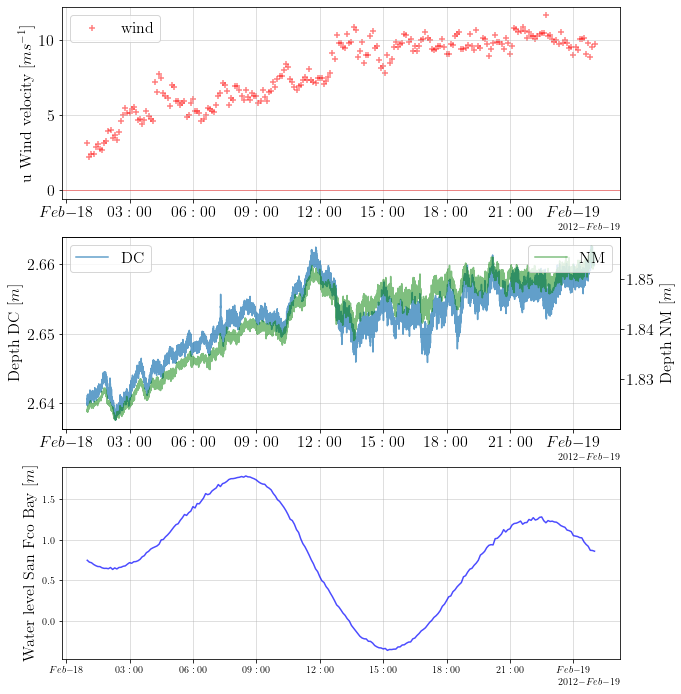

In [107]:
fig, (ax4, ax2, ax5) = plt.subplots(nrows=3, figsize=(10, 12))

locator1 = mdates.AutoDateLocator()
formatter1 = mdates.ConciseDateFormatter(locator1)
locator2 = mdates.AutoDateLocator()
formatter2 = mdates.ConciseDateFormatter(locator2)

dat1 = df
datw1 = dfw.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

prof_DC = DC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
prof_NM = NM_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

# ax1.plot(dat1.time.values, dat1.isel(bin=9), alpha=0.7);
# ax1.legend(["bin 10"], loc='upper right', fontsize=16);
# ax1.set_ylabel('Velocity $[m^2/s]$', fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.axhline(y=0, color='b', linewidth=0.5, alpha=0.8)

ax2.plot(prof_DC.index, prof_DC['Depth'], alpha=0.7);
ax2.set_ylabel('Depth DC $[m]$', fontsize=16)
# ax2.set_ylim(2.64, 2.68)
ax2.grid(alpha=0.5)
ax2.legend(["DC"], loc='upper left',
          fontsize=16);

ax3 = ax2.twinx()
ax3.set_ylabel(r"Depth NM $[m]$",
          fontsize=16)
ax3.plot(prof_NM.index, prof_NM['Depth'], alpha=0.5, c='g');
# ax3.set_ylim(1.82, 1.86)
ax3.legend(["NM"], loc='upper right',
          fontsize=16);

ax4.set_ylabel(r"u Wind velocity $[ms^{-1}]$",
          fontsize=16)
ax4.scatter(datw1.index, -datw1['u'], color='r',alpha=0.5, marker='+')
ax4.legend(["wind"], loc='upper left', fontsize=16);
ax4.axhline(y=0, color='r', linewidth=0.5, alpha=0.8)
ax4.grid(alpha=0.5)

ax5.set_ylabel(r"Water level San Fco Bay $[m]$",
          fontsize=16)
ax5.plot(sf.index, sf.values, color='b',alpha=0.7)
ax5.grid(alpha=0.5)

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)


ax1.xaxis.set_major_locator(locator1)
ax1.xaxis.set_major_formatter(formatter1)
ax2.xaxis.set_major_locator(locator2)
ax2.xaxis.set_major_formatter(formatter2)
ax3.xaxis.set_major_locator(locator2)
ax3.xaxis.set_major_formatter(formatter2)

ax4.xaxis.set_major_locator(locator1)
ax4.xaxis.set_major_formatter(formatter1)
ax5.xaxis.set_major_locator(locator1)
ax5.xaxis.set_major_formatter(formatter1)

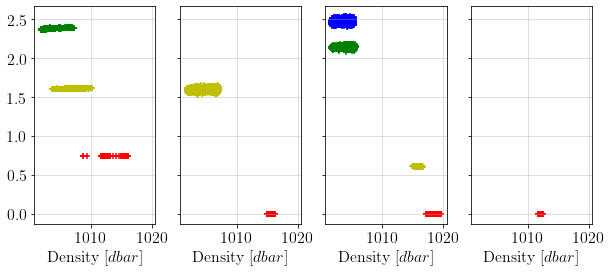

In [108]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(10, 4), sharey=True, sharex=True)

ax1.scatter(nm1['densidad'], nm1['Depth']-nm1['Depth'] + 0.742830, marker='+',color='r')
ax1.scatter(nm2['densidad'], nm1.loc[nm3.index]['Depth']-nm2['Depth'] + 0.742830, marker='+',color='y')
ax1.scatter(nm3['densidad'], nm1.loc[nm3.index]['Depth']-nm3['Depth'] + 0.742830, marker='+',color='g')
ax1.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2.scatter(ml1['densidad'], ml1['Depth']-ml1['Depth'], marker='+',color='r')
ax2.scatter(ml2['densidad'], ml1['Depth']-ml2['Depth'], marker='+',color='y')
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r')
ax3.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y')
ax3.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g')
ax3.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b')
ax3.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

ax4.scatter(pc1['densidad'], pc1['Depth']-pc1['Depth'], marker='+',color='r')
ax4.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax4.grid(alpha=0.5)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)

In [109]:
nm1.loc[nm3.index]

,Depth,Salinity,Temperature,densidad
Datetime,,,,
2012-02-18 01:00:00,1.823735,21.836169,14.377385,1015.902544
2012-02-18 01:00:30,1.824097,21.823144,14.369577,1015.894053
2012-02-18 01:01:00,1.824396,16.772846,14.357074,1012.036187
2012-02-18 01:01:30,1.824078,21.695198,14.362033,1015.797613
2012-02-18 01:02:00,1.824167,21.823188,14.359673,1015.895950
...,...,...,...,...
2012-02-19 00:58:00,1.853946,21.207294,14.608054,1015.378316
2012-02-19 00:58:30,1.852816,21.202063,14.608747,1015.374181
2012-02-19 00:59:00,1.853692,21.201491,14.607440,1015.373996


<ipython-input-110-6f6d80006003>:42: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


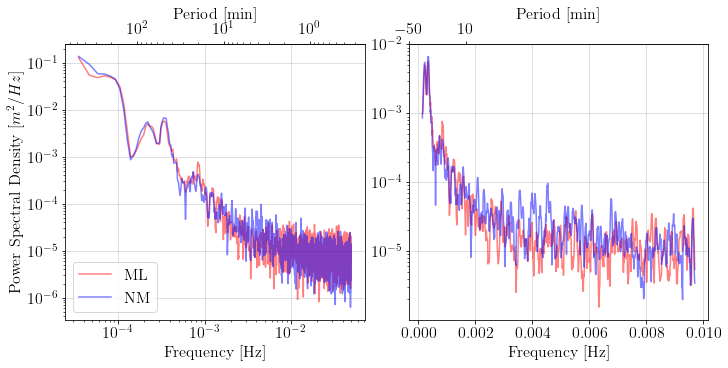

In [110]:
h_dc = prof_DC['Depth'] - prof_DC['Depth'].mean()
h_nm = prof_NM['Depth'] - prof_NM['Depth'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='ML')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='NM')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [1.31969058e-04, 2.49367089e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

In [37]:
DC_1

,Depth,Salinity,Temperature,densidad
Datetime,,,,
2012-02-01 00:00:00,1.714886,32.434821,11.958772,1024.498347
2012-02-01 00:00:10,1.714555,32.433081,11.958518,1024.497049
2012-02-01 00:00:20,1.714757,32.434433,11.958733,1024.498054
2012-02-01 00:00:30,1.714036,32.434056,11.958747,1024.497757
2012-02-01 00:00:40,1.714195,32.433801,11.958699,1024.497570
...,...,...,...,...
2012-03-14 23:59:20,1.973828,0.318607,11.051642,999.861492
2012-03-14 23:59:30,1.973727,0.272359,11.090772,999.821342
2012-03-14 23:59:40,1.974231,0.277028,11.098773,999.824167


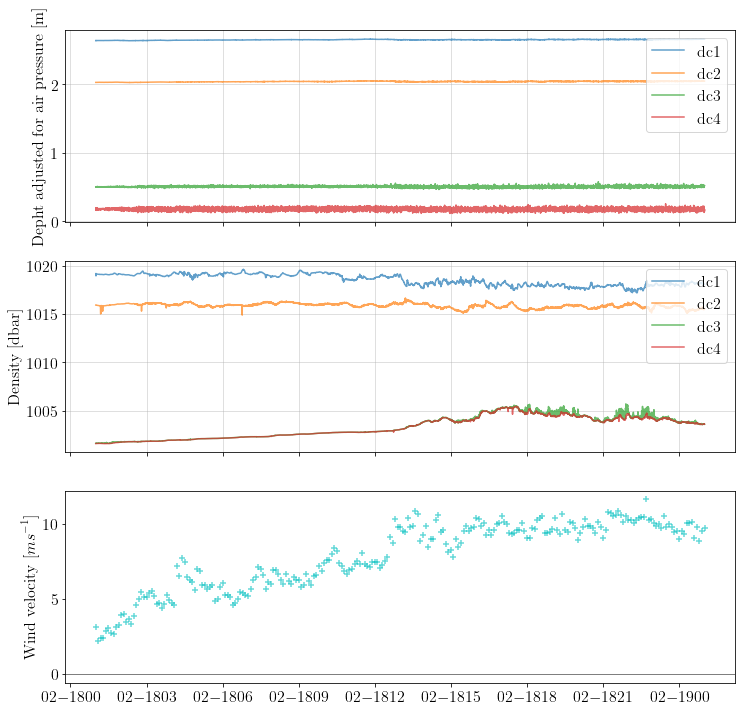

In [44]:
x_dc1 = DC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)].index
y_dc1 = DC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['Depth'].values
x_dc2 = DC_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)].index
y_dc2 = DC_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['Depth'].values
x_dc3 = DC_3.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)].loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)].index
y_dc3 = DC_3.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['Depth'].values
x_dc4 = DC_4.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)].index
y_dc4 = DC_4.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['Depth'].values
rho_dc1 = DC_1.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['densidad'].values
rho_dc2 = DC_2.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['densidad'].values
rho_dc3 = DC_3.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['densidad'].values
rho_dc4 = DC_4.loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]['densidad'].values

wdf = dfw['u'].loc[datetime.datetime(2012,2,18,1,0,0):datetime.datetime(2012,2,19,1,0,0)]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

ax1.plot(x_dc1,y_dc1, alpha=0.7);
ax1.plot(x_dc2,y_dc2, alpha=0.7);
ax1.plot(x_dc3,y_dc3, alpha=0.7);
ax1.plot(x_dc4,y_dc4, alpha=0.7);
ax1.legend(["dc1","dc2", "dc3", "dc4"], loc='upper right',
          fontsize=16);
ax1.set_ylabel('Depht adjusted for air pressure [m]',
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2.plot(x_dc1,rho_dc1, alpha=0.7);
ax2.plot(x_dc2,rho_dc2, alpha=0.7);
ax2.plot(x_dc3,rho_dc3, alpha=0.7);
ax2.plot(x_dc4,rho_dc4, alpha=0.7);
ax2.legend(["dc1","dc2", "dc3", "dc4"], loc='upper right',
          fontsize=16);
ax2.set_ylabel('Density [dbar]',
          fontsize=16)
ax2.grid(alpha=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c', marker = '+', alpha=0.6)
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)

### Tramo verde

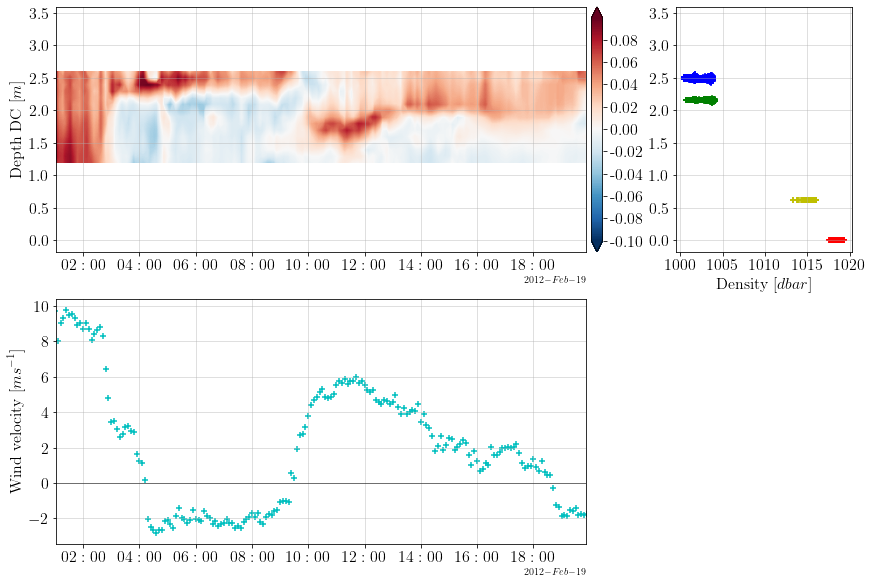

In [111]:
df = bu1.sel(time=slice("2012-02-19 1:00:00","2012-02-19 20:00:00"))
wdf = dfw['u'].loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig)


# ax1.set_title(r"Velocity 1st breach "
#           r"$\displaystyle(ms^{-1})$",
#           fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

ax1 = fig.add_subplot(gs[0, :6])
contourf_ = ax1.contourf(df.time.values, y_bin,
                         np.transpose(df.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax3 =  fig.add_subplot(gs[1, :6],sharex=ax1)
ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c',marker='+')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(gs[0, 6:], sharey=ax1)
ax2.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r')
ax2.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y')
ax2.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g')
ax2.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b')
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.show() 

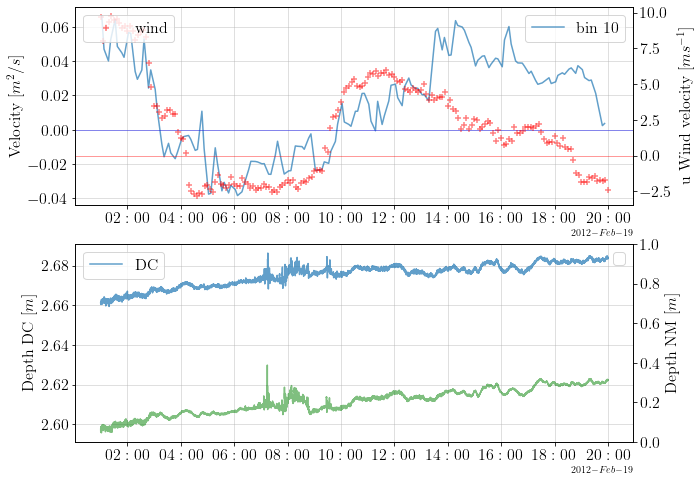

In [112]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8))

locator1 = mdates.AutoDateLocator()
formatter1 = mdates.ConciseDateFormatter(locator1)
locator2 = mdates.AutoDateLocator()
formatter2 = mdates.ConciseDateFormatter(locator2)

dat1 = df
datw1 = dfw.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]

prof_DC = DC_1.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]
prof_NM = NM_1.loc[datetime.datetime(2012,2,19,1,0,0):datetime.datetime(2012,2,19,20,0,0)]

ax1.plot(dat1.time.values, dat1.isel(bin=9), alpha=0.7);
ax1.legend(["bin 10"], loc='upper right', fontsize=16);
ax1.set_ylabel('Velocity $[m^2/s]$', fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='b', linewidth=0.5, alpha=0.8)

ax2.plot(prof_DC.index, prof_DC['Depth'], alpha=0.7);
ax2.set_ylabel('Depth DC $[m]$', fontsize=16)
# ax2.set_ylim(2.66, 2.7)
ax2.grid(alpha=0.5)
ax2.legend(["DC"], loc='upper left',
          fontsize=16);

ax3 = ax2.twinx()
ax3.set_ylabel(r"Depth NM $[m]$",
          fontsize=16)
ax2.plot(prof_NM.index, prof_NM['Depth'] + 0.742830, alpha=0.5, c='g');
# ax3.set_ylim(1.85, 1.89)
ax3.legend(["NM"], loc='upper right',
          fontsize=16);

ax4 = ax1.twinx()
ax4.set_ylabel(r"u Wind velocity $[ms^{-1}]$",
          fontsize=16)
ax4.scatter(datw1.index, -datw1['u'], color='r',alpha=0.5, marker='+')
ax4.legend(["wind"], loc='upper left', fontsize=16);
ax4.axhline(y=0, color='r', linewidth=0.5, alpha=0.8)

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)


ax1.xaxis.set_major_locator(locator1)
ax1.xaxis.set_major_formatter(formatter1)
ax2.xaxis.set_major_locator(locator2)
ax2.xaxis.set_major_formatter(formatter2)
ax3.xaxis.set_major_locator(locator2)
ax3.xaxis.set_major_formatter(formatter2)

ax4.xaxis.set_major_locator(locator1)
ax4.xaxis.set_major_formatter(formatter1)

<ipython-input-113-6f6d80006003>:42: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


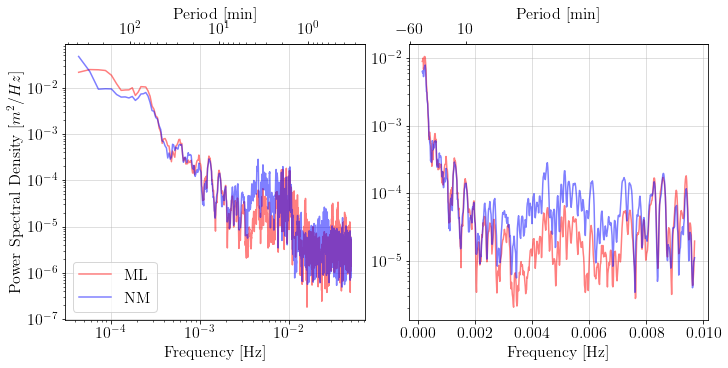

In [113]:
h_dc = prof_DC['Depth'] - prof_DC['Depth'].mean()
h_nm = prof_NM['Depth'] - prof_NM['Depth'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='ML')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='NM')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [1.31969058e-04, 2.49367089e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

### Tramo rojo

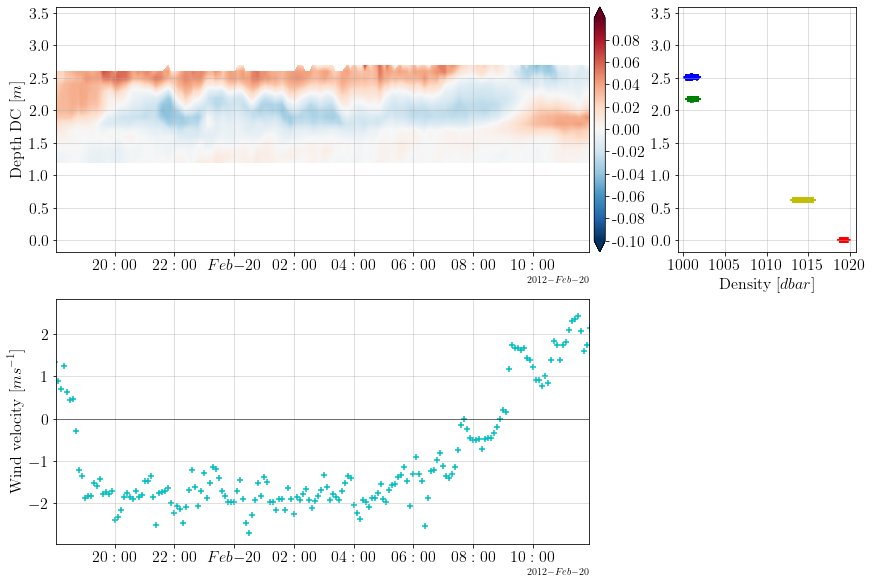

In [114]:
#Tramo rojo
df = bu1.sel(time=slice("2012-02-19 18:00:00","2012-02-20 12:00:00"))
wdf = dfw['u'].loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
dc1 = DC_1.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
y_bin = np.linspace(1.19, 3.59, 25)
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(2, 8, figure=fig)


# ax1.set_title(r"Velocity 1st breach "
#           r"$\displaystyle(ms^{-1})$",
#           fontsize=16)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
# ax1.plot(x, y_d,color='k',alpha=0.5)

ax1 = fig.add_subplot(gs[0, :6])
contourf_ = ax1.contourf(df.time.values, y_bin,
                         np.transpose(df.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.01)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))

ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax3 =  fig.add_subplot(gs[1, :6],sharex=ax1)
ax3.set_ylabel(r"Wind velocity "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.scatter(wdf.index, -wdf.values,color='c',marker='+')
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(gs[0, 6:], sharey=ax1)
ax2.scatter(dc1['densidad'], dc1['Depth']-dc1['Depth'], marker='+',color='r')
ax2.scatter(dc2['densidad'], dc1['Depth']-dc2['Depth'], marker='+',color='y')
ax2.scatter(dc3['densidad'], dc1['Depth']-dc3['Depth'], marker='+',color='g')
ax2.scatter(dc4['densidad'], dc1['Depth']-dc4['Depth'], marker='+',color='b')
ax2.set_xlabel(r"Density "
          r"$\displaystyle[dbar]$",
          fontsize=16)
ax2.grid(alpha=0.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

plt.show() 

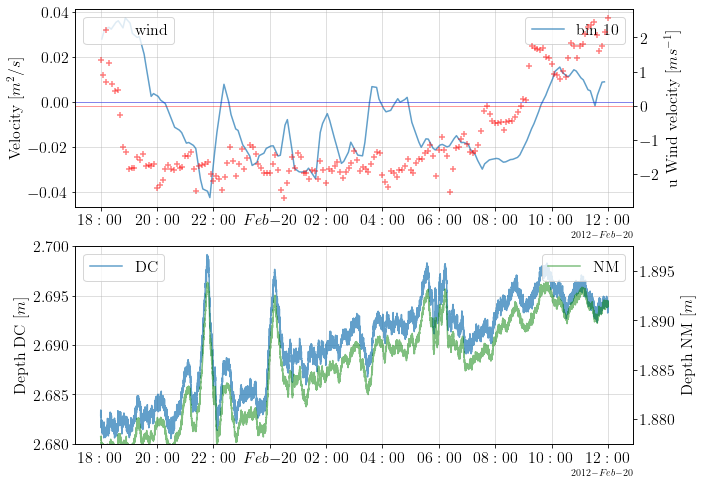

In [115]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8))

locator1 = mdates.AutoDateLocator()
formatter1 = mdates.ConciseDateFormatter(locator1)
locator2 = mdates.AutoDateLocator()
formatter2 = mdates.ConciseDateFormatter(locator2)

dat1 = bu1.sel(time=slice("2012-02-19 18:00:00","2012-02-20 12:00:00"))
datw1 = dfw.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]

prof_DC = DC_1.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]
prof_NM = NM_1.loc[datetime.datetime(2012,2,19,18,0,0):datetime.datetime(2012,2,20,12,0,0)]

ax1.plot(dat1.time.values, dat1.isel(bin=9), alpha=0.7);
ax1.legend(["bin 10"], loc='upper right', fontsize=16);
ax1.set_ylabel('Velocity $[m^2/s]$', fontsize=16)
ax1.grid(alpha=0.5)
ax1.axhline(y=0, color='b', linewidth=0.5, alpha=0.8)

ax2.plot(prof_DC.index, prof_DC['Depth'], alpha=0.7);
ax2.set_ylabel('Depth DC $[m]$', fontsize=16)
ax2.set_ylim(2.68, 2.7)
ax2.grid(alpha=0.5)
ax2.legend(["DC"], loc='upper left',
          fontsize=16);

ax3 = ax2.twinx()
ax3.set_ylabel(r"Depth NM $[m]$",
          fontsize=16)
ax3.plot(prof_NM.index, prof_NM['Depth'], alpha=0.5, c='g');
ax3.set_ylim(1.8775, 1.8975)
ax3.legend(["NM"], loc='upper right',
          fontsize=16);

ax4 = ax1.twinx()
ax4.set_ylabel(r"u Wind velocity $[ms^{-1}]$",
          fontsize=16)
ax4.scatter(datw1.index, -datw1['u'], color='r',alpha=0.5, marker='+')
ax4.legend(["wind"], loc='upper left', fontsize=16);
ax4.axhline(y=0, color='r', linewidth=0.5, alpha=0.8)

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)


ax1.xaxis.set_major_locator(locator1)
ax1.xaxis.set_major_formatter(formatter1)
ax2.xaxis.set_major_locator(locator2)
ax2.xaxis.set_major_formatter(formatter2)
ax3.xaxis.set_major_locator(locator2)
ax3.xaxis.set_major_formatter(formatter2)

ax4.xaxis.set_major_locator(locator1)
ax4.xaxis.set_major_formatter(formatter1)

<ipython-input-116-6f6d80006003>:42: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


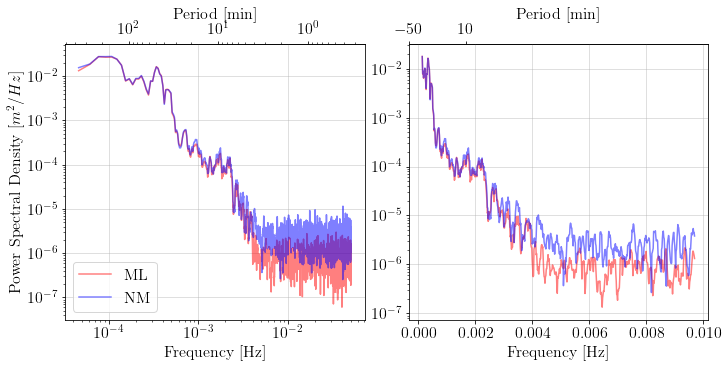

In [116]:
h_dc = prof_DC['Depth'] - prof_DC['Depth'].mean()
h_nm = prof_NM['Depth'] - prof_NM['Depth'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='ML')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='NM')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [1.31969058e-04, 2.49367089e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

# Funciones (correr antes)

In [12]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [13]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [14]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [15]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [16]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=10, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [17]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)